# Example 6 - Multi-objective optimization for an ellipse function

In this example, we will demonstrate how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front. We will use a hyperthetical function which has a shape of an ellispe:

$ y_1 = x $ and $ y_2 = \sqrt{(1 - x^2/4)} $

where $ y_1^2 + y_2^2/4 = 1 $. `x` is the only input parameter. `y1` and `y2` are two output reponses which cannot be optimized jointly. 

Multi-objective optimization derives a set of solutions that define the tradeoff between competing objectives. The boundary defined by the entire feasible solution set is called the Pareto front. 

In `nextorch`, we implement weighted sum method to construct the Pareto front. It is commonly used for convex problems. A set of objectives are scalarized to a single objective by adding each objective pre-multiplied by a user-supplied weight. The weight of an objective is chosen in proportion to its relative importance. The optimization is simply performed with respected to the scalarized objective. By varying the weight combinations, we can construct the whole Pareto front. 

For this example, the scalarized objective can be written as,
$$ y = w_1 y_1 + w_2 y_2 $$
where the weights $ w_1, w_2 \in [0, 1] $ and $w_1 + w_2 = 1 $.

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :----------------- |
| Goal | Maximization, two objectives |
| Objective function | Ellipse function |
| Input (X) dimension | 1 |
| Output (Y) dimension | 2 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.

## 1. Import `nextorch` and other packages

In [1]:
import numpy as np
from nextorch import plotting, bo, doe, utils, io

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR` as the objective function `objective_func`. 

The ranges of the input X are specified. 

In [2]:
#%% Define the objective function
def ellipse(X_real):
    """ellipse function

    Parameters
    ----------
    X_real : numpy matrix
        input parameter

    Returns
    -------
    Y_real: numpy matrix
        y1 and y2
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    y1 = X_real.copy()
    y2 = np.sqrt(1 - X_real**2/4)
    
    Y_real = np.concatenate((y1, y2), axis = 1)
        
    return Y_real # y1, y2


# Objective function
objective_func = ellipse


#%% Define the design space
X_name = ['x']
    
# two outputs
Y_names = [r'$\rm y_1$', r'$\rm y_2$']

# combine X and Y names
var_names = X_name + Y_names

# Set the operating range for each parameter
X_ranges =  [[0, 2]]

# Get the information of the design space
n_dim = 1 # the dimension of inputs
n_objective = 2 # the dimension of outputs

## 3. Define the initial sampling plan
Here we use LHC design with 10 points for the initial sampling. The initial reponse in a real scale `Y_init_real` is computed from the objective function.

In [3]:
#%% Initial Sampling 
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

## 4. Initialize an `Experiment` object 

In this example, we use an `MOOExperiment` object, a class designed for multi-objective optimization. It can handle multiple weight combinations, perform the scalarized objective optimization automatically, and construct the entire Pareto front. 

An `MOOExperiment` is a subclass of `Experiment`. It requires all key components as `Experiment`:
- Name of the experiment, used for output folder name
- Input independent variables X: `X_init` or `X_init_real`
- List of X ranges: `X_ranges`
- Output dependent variables Y: `Y_init` or `Y_init_real`

Optional:
- `unit_flag`: `True` if the input X matrix is a unit scale, else `False`
- `objective_func`: Used for test plotting
- `maximize`: `True` if we look for maximum, else `False` for minimum

Additionally, `weights` is required for `MOOExperiment.set_optim_specs` function. It defines a list of weights for objective 1. The weights of objective 2 is 1 minus that of objective 1. Under the hood, each weight combination correponds to a single `Experiment` object, each with a different scalarized objective. 

Some progress status will be printed out while initializing all single `Experiment` objects.

In [4]:
#%% Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.MOOExperiment('ellipse_MOO')  
# Import the initial data
Exp_lhc.input_data(X_init_lhc, 
                   Y_init_lhc, 
                   X_ranges = X_ranges, 
                   X_names = X_name,
                   Y_names = Y_names,
                   unit_flag = False)

# Set the optimization specifications 
# here we set the objective function, minimization by default
# 10 weights, 10 Experiments
n_exp = 21 # number of single Experiments

# Set a weight vector for objective 1
weights_obj_1 = np.linspace(0, 1, n_exp)
weights_obj_2 = 1 - weights_obj_1

# Set a timer
start_time = time.time()
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize = True, 
                        weights = weights_obj_1)
end_time = time.time()
print('Initializing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Initializing 21 experiments
Iter 10/100: 5.723519802093506
Iter 20/100: 5.23295783996582
Iter 30/100: 4.6133880615234375
Iter 40/100: 1.9704277515411377
Iter 50/100: 1.5127692222595215
Iter 60/100: 1.410210371017456
Iter 70/100: 1.32535719871521
Iter 80/100: 1.2745541334152222
Iter 90/100: 1.2467190027236938
Iter 100/100: 1.226029396057129
Initializing experiments 4.76 % 
Iter 10/100: 5.723519802093506
Iter 20/100: 5.23295783996582
Iter 30/100: 4.6133880615234375
Iter 40/100: 1.9704277515411377
Iter 50/100: 1.5127692222595215
Iter 60/100: 1.410210371017456
Iter 70/100: 1.32535719871521
Iter 80/100: 1.2745541334152222
Iter 90/100: 1.2467190027236938
Iter 100/100: 1.226029396057129
Initializing experiments 9.52 % 
Iter 10/100: 5.723519802093506
Iter 20/100: 5.23295783996582
Iter 30/100: 4.6133880615234375
Iter 40/100: 1.9704277515411377
Iter 50/100: 1.5127692222595215
Iter 60/100: 1.410210371017456
Iter 70/100: 1.32535719871521
Iter 80/100: 1.2745541334152222
Iter 90/100: 1.2467190027236

## 5. Run trials 

At each weight combinations, we perform an optimization task for the scalarized objective (a single `Experiment`). `MOOExperiment.run_exp_auto` run these tasks automatically by using the default choice of acqucision function, Expected improvement (EI). It takes in the number of trials required for each `Experiment`. The number of trials needs to be large enough which allows Bayesian Optimization algorithm to converge to the optimum. Nevertheless, the optimization of `y1` and `y2` are rather trivial due to their simple analytical expression. We will do 10 trials for each experiment. The total number of calls for the objective function is `n_trails` * `n_exp` (=210). 

Some progress status will be printed out during the training.

In [5]:
# Set the number of iterations for each experiments
n_trials_lhc = 10 
# Set a timer
start_time = time.time()
Exp_lhc.run_exp_auto(n_trials_lhc)

end_time = time.time()
print('Optimizing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Running 21 experiments
Iter 10/100: 0.5434869527816772
Iter 20/100: 0.508520781993866
Iter 30/100: 0.47558531165122986
Iter 40/100: 0.45306968688964844
Iter 50/100: 0.43230125308036804
Iter 60/100: 0.4158894121646881
Iter 70/100: 0.40274715423583984
Iter 80/100: 0.3892427086830139
Iter 90/100: 0.37743932008743286
Running experiments 4.76 % 
Iter 10/100: 1.3625149726867676
Iter 20/100: 1.3488014936447144
Iter 30/100: 1.3398540019989014
Iter 40/100: 1.3346573114395142
Iter 10/100: 3.4873924255371094
Iter 10/100: 2.468198299407959
Running experiments 9.52 % 
Iter 10/100: 1.3625149726867676
Iter 20/100: 1.3488014936447144
Iter 30/100: 1.3398540019989014
Iter 40/100: 1.3346573114395142
Running experiments 14.29 % 
Iter 10/100: 1.3625149726867676
Iter 20/100: 1.3488014936447144
Iter 30/100: 1.3398540019989014
Iter 40/100: 1.3346573114395142
Running experiments 19.05 % 
Iter 10/100: 1.3625149726867676
Iter 20/100: 1.3488014936447144
Iter 30/100: 1.3398540019989014
Iter 40/100: 1.3346573114395

## 6. Visualize the Pareto front
We can get the Pareto set directly from the `MOOExperiment` object by using `MOOExperiment.get_optim`.

To visualize the Pareto front, `y1` values are plotted against `y2` values. The scatter points resemble an ellispe shape, incidating the method is able to map out the entire front. 

,$\rm w_1$,$\rm w_2$,x,$\rm y_1$,$\rm y_2$
0,0.00,1.00,0.00,0.00,1.00
1,0.05,0.95,0.26,0.26,0.99
2,0.10,0.90,0.20,0.40,0.98
3,0.15,0.85,0.33,0.66,0.94
4,0.20,0.80,0.41,0.83,0.91
5,0.25,0.75,1.14,1.14,0.82
6,0.30,0.70,1.26,1.26,0.78
7,0.35,0.65,0.73,1.47,0.68
8,0.40,0.60,1.58,1.58,0.61
9,0.45,0.55,1.68,1.68,0.54


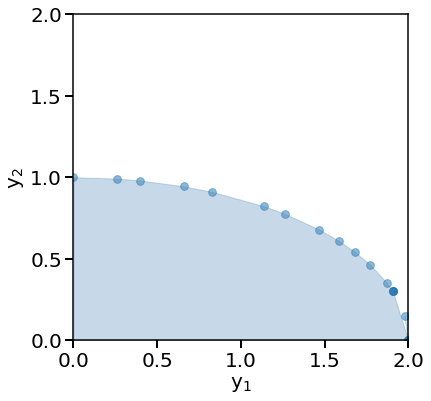

In [6]:
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = Exp_lhc.get_optim()
weight_names = [r'$\rm w_1$', r'$\rm w_2$'] 

# Parse the optimum into a table
data_opt = io.np_to_dataframe([weights_obj_1, weights_obj_2, X_real_opts, Y_real_opts], weight_names + var_names, n = n_exp)
display(data_opt.round(decimals=2))

# Make the pareto plots 
plotting.pareto_front_exp(Exp_lhc, fill = True, diagonal = False)

[Thumbnail](_images/06.png) of this notebook